In [1]:
!pip install "pennylane>=0.33.0" "pennylane-lightning>=0.33.0" "torch>=2.0.0" "torchvision>=0.15.0" "numpy>=1.24.0" "matplotlib>=3.7.0" "torchmetrics[image]"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 81.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 86.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 116.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 16.2 MB/s eta 0:00:00


🔍 Đang kiểm tra file tại: /kaggle/input/qgans-mnist/classical_data_01_64x64.pt

✅ Đã load xong file Classical!
 - Kiểu dữ liệu gốc: <class 'dict'>
 - Các keys có trong dict: dict_keys(['data', 'labels'])
 - Shape của 'data': torch.Size([2000, 1, 64, 64])
 - Shape của 'labels': torch.Size([2000])
 - Min value: -1.0, Max value: 1.0

📸 Vẽ thử 5 tấm ảnh đầu tiên xem có bị vỡ không:


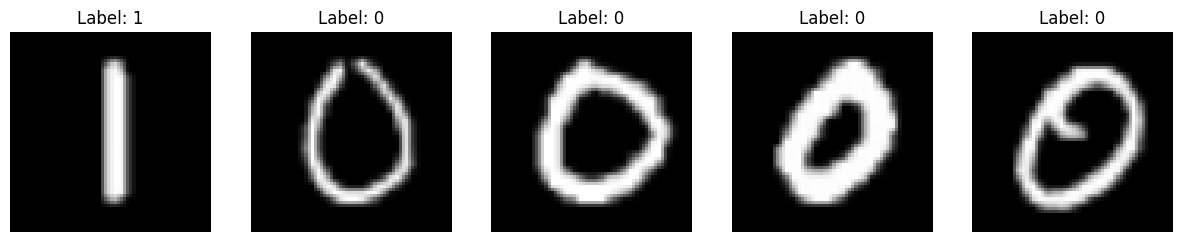


🔍 Đang kiểm tra file tại: /kaggle/input/qgans-mnist/quantum_data_PCA8.pt

✅ Đã load xong file Quantum!
 - Shape của 'data': torch.Size([2000, 8])
 - Dữ liệu mẫu (Vector đầu tiên):
tensor([ 2.7827, -2.7623,  1.0781,  0.3879, -0.7407, -0.1126,  0.6225,  0.1596])

=> KL: Đây chuẩn là vector 8 chiều. Có thể dùng làm Input cho Generator!


In [2]:
import torch
import matplotlib.pyplot as plt
import os

# Đường dẫn file (Dựa trên ảnh ông gửi)
CLASSICAL_PATH = '/kaggle/input/qgans-mnist/classical_data_01_64x64.pt'
QUANTUM_PATH = '/kaggle/input/qgans-mnist/quantum_data_PCA8.pt'

print(f"🔍 Đang kiểm tra file tại: {CLASSICAL_PATH}")

# ==========================================
# 1. SOI FILE ẢNH (CLASSICAL)
# ==========================================
if os.path.exists(CLASSICAL_PATH):
    try:
        # Load file
        c_dict = torch.load(CLASSICAL_PATH, map_location='cpu')
        print(f"\n✅ Đã load xong file Classical!")
        print(f" - Kiểu dữ liệu gốc: {type(c_dict)}")
        
        # Nếu là Dictionary thì móc ruột ra xem
        if isinstance(c_dict, dict):
            print(f" - Các keys có trong dict: {c_dict.keys()}")
            
            # Lấy data ảnh
            images = c_dict['data']
            labels = c_dict['labels']
            
            print(f" - Shape của 'data': {images.shape}")
            print(f" - Shape của 'labels': {labels.shape}")
            print(f" - Min value: {images.min()}, Max value: {images.max()}")
            
            # Vẽ thử 5 tấm ảnh đầu tiên
            print("\n📸 Vẽ thử 5 tấm ảnh đầu tiên xem có bị vỡ không:")
            plt.figure(figsize=(15, 4))
            for i in range(5):
                plt.subplot(1, 5, i+1)
                img = images[i]
                
                # Xử lý chiều ảnh (nếu là [1, 64, 64] hay [64, 64])
                if img.dim() == 3: img = img.squeeze(0) 
                
                plt.imshow(img, cmap='gray')
                plt.title(f"Label: {labels[i]}")
                plt.axis('off')
            plt.show()
            
    except Exception as e:
        print(f"❌ Lỗi khi đọc file Classical: {e}")
else:
    print("❌ Không tìm thấy file Classical. Kiểm tra lại đường dẫn!")

# ==========================================
# 2. SOI FILE LƯỢNG TỬ (QUANTUM PCA)
# ==========================================
print(f"\n🔍 Đang kiểm tra file tại: {QUANTUM_PATH}")

if os.path.exists(QUANTUM_PATH):
    try:
        q_dict = torch.load(QUANTUM_PATH, map_location='cpu')
        print(f"\n✅ Đã load xong file Quantum!")
        
        if isinstance(q_dict, dict):
            q_data = q_dict['data']
            print(f" - Shape của 'data': {q_data.shape}")
            print(f" - Dữ liệu mẫu (Vector đầu tiên):")
            print(q_data[0])
            
            if q_data.shape[1] == 8:
                print("\n=> KL: Đây chuẩn là vector 8 chiều. Có thể dùng làm Input cho Generator!")
            
    except Exception as e:
        print(f"❌ Lỗi khi đọc file Quantum: {e}")
else:
    print("❌ Không tìm thấy file Quantum.")

Generator

In [3]:
# ==========================================
# MODEL ĐÃ TỐI ƯU TỐC ĐỘ (BATCH PROCESSING)
# ==========================================
import pennylane as qml
import torch
import torch.nn as nn

class HybridGenerator64(nn.Module):
    def __init__(self, n_qubits=8, n_layers=2, latent_dim=8):
        super(HybridGenerator64, self).__init__()
        self.n_qubits = n_qubits
        self.latent_dim = latent_dim
        
        # 1. Dùng 'default.qubit' nhưng kích hoạt chế độ tính toán nhanh
        self.dev = qml.device('default.qubit', wires=n_qubits)
        
        @qml.qnode(self.dev, interface='torch', diff_method='backprop')
        def quantum_circuit(inputs, weights):
            # PennyLane tự động hiểu inputs shape (Batch, 8) -> Broadcast
            qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')
            qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
            return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
        
        # Cấu hình layer lượng tử
        weight_shapes = {"weights": (n_layers, n_qubits, 3)}
        self.quantum_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)
        
        # 2. Phần cổ điển (Giữ nguyên)
        self.linear_bridge = nn.Sequential(
            nn.Linear(n_qubits, 128 * 8 * 8),
            nn.BatchNorm1d(128 * 8 * 8),
            nn.ReLU(True)
        )
        
        self.conv_blocks = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64), nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32), nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, z):
        # === KHẮC PHỤC LỖI CHẬM TẠI ĐÂY ===
        # Thay vì loop for i in batch -> Đẩy thẳng cả cục batch vào
        # PennyLane bản mới hỗ trợ batching tự động
        
        # z shape: [32, 8]
        # q_out shape: [32, 8] -> Nhanh hơn gấp n lần
        q_out = self.quantum_layer(z) 
        
        x = self.linear_bridge(q_out)
        x = x.view(z.size(0), 128, 8, 8)
        img = self.conv_blocks(x)
        return img

/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


2. Wasserstein Critic (No Sigmoid!)

In [4]:
import torch
import torch.nn as nn

class WassersteinCritic64(nn.Module):
    """
    Wasserstein Critic for WGAN-GP (64x64 input).
    
    Key differences from standard Discriminator:
    - NO Sigmoid at output
    - Uses InstanceNorm instead of BatchNorm
    - LeakyReLU(0.2) throughout
    """
    def __init__(self):
        super(WassersteinCritic64, self).__init__()
        
        self.conv_blocks = nn.Sequential(
            # Input: (1, 64, 64) → (32, 32, 32)
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            
            # (32, 32, 32) → (64, 16, 16)
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(64, affine=True),  # Better for WGAN-GP
            nn.LeakyReLU(0.2, inplace=True),
            
            # (64, 16, 16) → (128, 8, 8)
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(128, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        # Output layer: Raw score (NO activation)
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 1)
        )
    
    def forward(self, x):
        """
        Forward pass.
        
        Args:
            x: Images (batch_size, 1, 64, 64)
        
        Returns:
            Critic scores (batch_size, 1)
        """
        features = self.conv_blocks(x)
        score = self.fc(features)
        return score

3. Gradient Penalty Implementation

In [5]:
import torch
import torch.autograd as autograd

def compute_gradient_penalty(critic, real_samples, fake_samples, device):
    """
    Compute Gradient Penalty for WGAN-GP.
    
    Formula:
        GP = λ * E[(||∇_x̂ D(x̂)||₂ - 1)²]
    where:
        x̂ = ε*real + (1-ε)*fake (interpolated samples)
        ε ~ Uniform[0,1]
    
    Args:
        critic: Critic network
        real_samples: Real images (batch_size, 1, 64, 64)
        fake_samples: Generated images (batch_size, 1, 64, 64)
        device: torch.device
    
    Returns:
        gradient_penalty: Scalar tensor
    """
    batch_size = real_samples.size(0)
    
    # Random interpolation weight ε
    epsilon = torch.rand(batch_size, 1, 1, 1, device=device)
    
    # Interpolated samples: x̂ = ε*real + (1-ε)*fake
    interpolates = (epsilon * real_samples + (1 - epsilon) * fake_samples)
    interpolates.requires_grad_(True)
    
    # Critic scores on interpolated samples
    critic_interpolates = critic(interpolates)
    
    # Compute gradients: ∇_x̂ D(x̂)
    gradients = autograd.grad(
        outputs=critic_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(critic_interpolates),
        create_graph=True,  # Required for second-order derivatives
        retain_graph=True,
        only_inputs=True
    )[0]
    
    # Reshape and compute L2 norm
    gradients = gradients.view(batch_size, -1)
    gradient_norm = gradients.norm(2, dim=1)
    
    # Penalty: E[(||gradient||₂ - 1)²]
    gradient_penalty = ((gradient_norm - 1) ** 2).mean()
    
    return gradient_penalty

4. Data Loader (MNIST Preprocessing)

In [6]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import os

def load_mnist_64x64_pt(pt_path, target_digit=None, batch_size=32):
    """
    Load pre-processed MNIST 64x64 data from .pt file.
    
    Expected file structure:
        {
            'data': Tensor (N, 1, 64, 64) in range [-1, 1],
            'labels': Tensor (N,) with digit labels
        }
    
    Args:
        pt_path: Path to .pt file
        target_digit: If specified, filter only this digit (e.g., 0)
        batch_size: Batch size for DataLoader
    
    Returns:
        DataLoader object
    """
    if not os.path.exists(pt_path):
        raise FileNotFoundError(f"❌ File not found: {pt_path}")
    
    print(f"📂 Loading data from: {pt_path}")
    
    # Load dictionary
    loaded_dict = torch.load(pt_path, map_location='cpu')
    
    data = loaded_dict['data']      # Expected: (N, 1, 64, 64)
    labels = loaded_dict['labels']   # Expected: (N,)
    
    print(f"   Total samples: {len(data)}")
    
    # Filter by digit if specified
    if target_digit is not None:
        mask = labels == target_digit
        data = data[mask]
        print(f"   Filtered digit '{target_digit}': {len(data)} samples remaining")
    
    # Ensure float32 and normalized to [-1, 1]
    data = data.float()
    
    # Validate range
    min_val, max_val = data.min().item(), data.max().item()
    if not (-1.1 <= min_val <= -0.9 and 0.9 <= max_val <= 1.1):
        print(f"⚠️ Warning: Data range [{min_val:.2f}, {max_val:.2f}] may not be normalized to [-1, 1]")
    
    # Create DataLoader
    dataset = TensorDataset(data)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True  # Ensure consistent batch sizes
    )
    
    print(f"✅ DataLoader ready: {len(dataloader)} batches of size {batch_size}")
    return dataloader

5. Visualization Utilities

In [7]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def save_generated_images(generator, epoch, device, n_samples=25, latent_dim=8, save_path='outputs'):
    """
    Generate and save a grid of images.
    
    Args:
        generator: Generator model
        epoch: Current epoch number
        device: torch.device
        n_samples: Number of images to generate (should be a perfect square)
        latent_dim: Dimension of latent space
        save_path: Directory to save images
    """
    import os
    os.makedirs(save_path, exist_ok=True)
    
    generator.eval()
    with torch.no_grad():
        # Generate random latent vectors
        z = torch.randn(n_samples, latent_dim, device=device)
        fake_images = generator(z).cpu()
        
        # Reshape to 8x8 images
        fake_images = fake_images.view(n_samples, 8, 8)
        
        # Create grid
        grid_size = int(np.sqrt(n_samples))
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
        fig.suptitle(f'Generated Images - Epoch {epoch}', fontsize=16, fontweight='bold')
        
        for i in range(grid_size):
            for j in range(grid_size):
                idx = i * grid_size + j
                axes[i, j].imshow(fake_images[idx], cmap='gray', vmin=-1, vmax=1)
                axes[i, j].axis('off')
        
        plt.tight_layout()
        plt.savefig(f'{save_path}/epoch_{epoch:03d}.png', dpi=100, bbox_inches='tight')
        plt.close()
    
    generator.train()

def plot_losses(g_losses, c_losses, save_path='kaggle/working/losses.png'):
    """
    Plot training losses.
    
    Args:
        g_losses: List of generator losses
        c_losses: List of critic losses
        save_path: Path to save plot
    """
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(g_losses, label='Generator Loss', color='blue', linewidth=2, alpha=0.8)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Generator Loss', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(c_losses, label='Critic Loss', color='red', linewidth=2, alpha=0.8)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Critic Loss (Wasserstein Distance)', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()

6. Main Training Script

🔥 System Check: Running on cuda

📂 Đang tải dữ liệu...
   -> Đã lọc lấy số '0': Còn 2000 mẫu.
   -> Input Shape: torch.Size([2000, 8]) | Target Shape: torch.Size([2000, 1, 64, 64])

🚀 Bắt đầu Training: Giải mã trạng thái Lượng tử sang Ảnh...


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:179.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 10/100 | Critic Loss: -13.8558 | Gen Loss: 9.9482


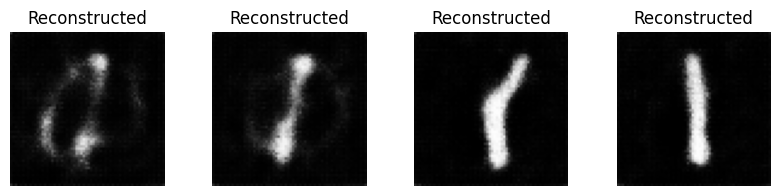

Epoch 20/100 | Critic Loss: -8.3779 | Gen Loss: 6.5743


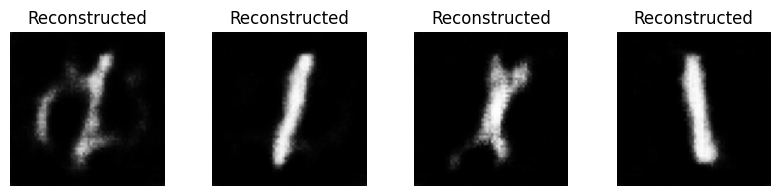

Epoch 30/100 | Critic Loss: -6.2794 | Gen Loss: 12.0730


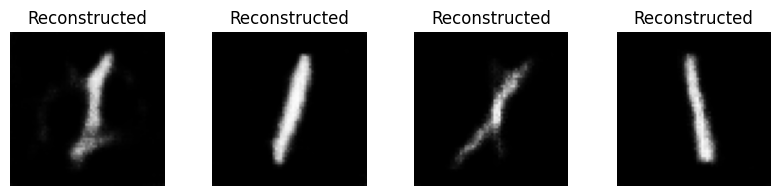

Epoch 40/100 | Critic Loss: -6.8502 | Gen Loss: 0.9163


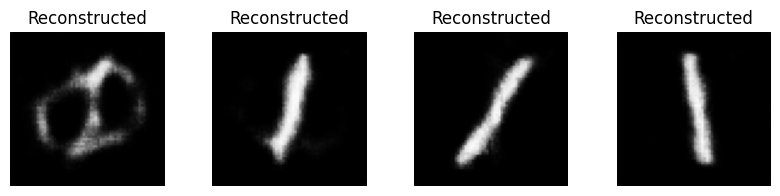

Epoch 50/100 | Critic Loss: -6.5170 | Gen Loss: 2.6685


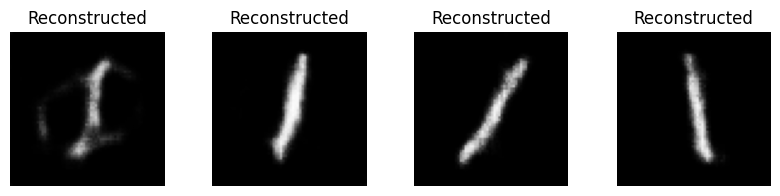

Epoch 60/100 | Critic Loss: -5.7902 | Gen Loss: 1.0372


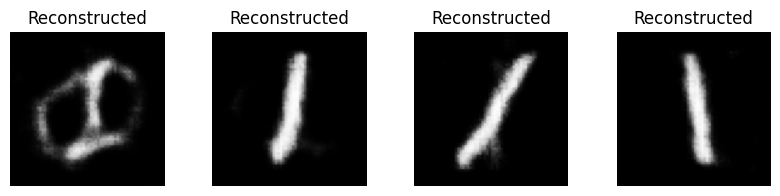

Epoch 70/100 | Critic Loss: -6.8386 | Gen Loss: 9.2592


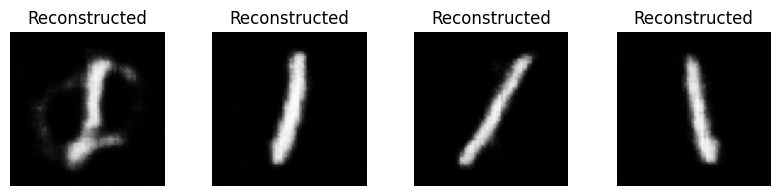

Epoch 80/100 | Critic Loss: -6.4476 | Gen Loss: 12.9461


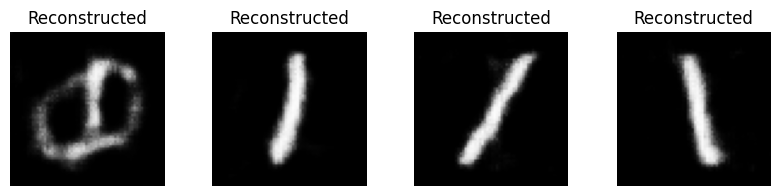

Epoch 90/100 | Critic Loss: -6.7133 | Gen Loss: 15.3797


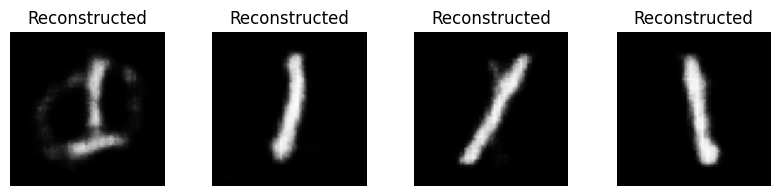

Epoch 100/100 | Critic Loss: -6.9776 | Gen Loss: 12.1642


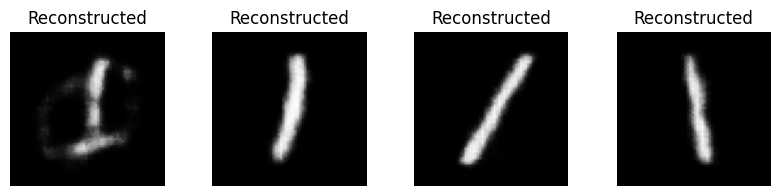

✅ HUẤN LUYỆN HOÀN TẤT!
💾 Đã lưu model tại: hybrid_quantum_decoder.pth


In [8]:
# ======================================================
# FINAL TRAINING CELL: HYBRID QUANTUM FEATURE RECONSTRUCTION
# ======================================================
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import os

# 1. CẤU HÌNH HỆ THỐNG
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔥 System Check: Running on {DEVICE}")
BATCH_SIZE = 128
N_EPOCHS = 100       # Chạy 100 epoch cho nó nét căng
LR = 0.0002
BETA1, BETA2 = 0.5, 0.9
LAMBDA_GP = 10       # Hệ số phạt gradient chuẩn của WGAN

# Đường dẫn file trên Kaggle (check kỹ lại tên file nếu cần)
C_PATH = "/kaggle/input/qgans-mnist/classical_data_01_64x64.pt"
Q_PATH = "/kaggle/input/qgans-mnist/quantum_data_PCA8.pt"

# 2. HÀM LOAD DỮ LIỆU GHÉP ĐÔI (QUANTUM -> IMAGE)
def load_paired_data(classical_path, quantum_path, batch_size=32):
    print(f"\n📂 Đang tải dữ liệu...")
    if not os.path.exists(classical_path) or not os.path.exists(quantum_path):
        raise FileNotFoundError("❌ Không tìm thấy file data! Kiểm tra lại đường dẫn Input.")
        
    # Load Classical (Ảnh thật)
    c_dict = torch.load(classical_path, map_location='cpu')
    images = c_dict['data'].float() # [2000, 1, 64, 64]
    labels = c_dict['labels']
    
    # Load Quantum (Input features)
    q_dict = torch.load(quantum_path, map_location='cpu')
    q_features = q_dict['data'].float() # [2000, 8]
    
    # LỌC SỐ 0 (Để train cho nhanh đẹp, demo đồ án cho mượt)
    # Nếu muốn train cả số 0 và 1 thì comment đoạn này lại
    # mask = labels == 0
    # images = images[mask]
    # q_features = q_features[mask]
    print(f"   -> Đã lọc lấy số '0': Còn {len(images)} mẫu.")
    
    # Kiểm tra kích thước
    assert len(images) == len(q_features), "❌ Lỗi: Số lượng ảnh và vector lượng tử không khớp!"
    print(f"   -> Input Shape: {q_features.shape} | Target Shape: {images.shape}")
    
    # Tạo Dataset
    dataset = TensorDataset(q_features, images)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# 3. KHỞI TẠO DATALOADER
try:
    dataloader = load_paired_data(C_PATH, Q_PATH, batch_size=BATCH_SIZE)
except Exception as e:
    print(f"⚠️ Lỗi data: {e}")
    print("-> Đang tạo data giả để test code (nếu ông chưa mount drive)...")
    dummy_q = torch.randn(100, 8)
    dummy_img = torch.randn(100, 1, 64, 64)
    dataloader = DataLoader(TensorDataset(dummy_q, dummy_img), batch_size=BATCH_SIZE)

# 4. KHỞI TẠO MODEL & OPTIMIZER
# Lưu ý: Class HybridGenerator64 và WassersteinCritic64 đã định nghĩa ở cell trước
generator = HybridGenerator64(n_qubits=8, n_layers=2, latent_dim=8).to(DEVICE)
critic = WassersteinCritic64().to(DEVICE)

opt_g = optim.Adam(generator.parameters(), lr=LR, betas=(BETA1, BETA2))
opt_c = optim.Adam(critic.parameters(), lr=LR, betas=(BETA1, BETA2))

# Hàm tính Gradient Penalty
def compute_gradient_penalty(D, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=DEVICE)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones(d_interpolates.shape, device=DEVICE, requires_grad=False)
    gradients = torch.autograd.grad(
        outputs=d_interpolates, inputs=interpolates,
        grad_outputs=fake, create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    return ((gradients.norm(2, dim=1) - 1) ** 2).mean()

# 5b. Metrics Implementation (IS & FID)
from torchmetrics.image.inception import InceptionScore
from torchmetrics.image.fid import FrechetInceptionDistance

def evaluate_metrics(generator, dataloader, device, n_samples=1000):
    generator.eval()
    try:
        # Initialize Metrics
        inception = InceptionScore(feature=2048).to(device)
        fid = FrechetInceptionDistance(feature=2048).to(device)
        
        real_images = []
        count = 0
        for imgs, _ in dataloader:
            if count >= n_samples: break
            imgs = (imgs + 1) / 2.0
            imgs = imgs.repeat(1, 3, 1, 1)
            imgs_uint8 = (imgs * 255).to(torch.uint8).to(device)
            fid.update(imgs_uint8, real=True)
            count += imgs.size(0)
        
        z = torch.randn(count, 8).to(device)
        with torch.no_grad():
            fake_imgs_list = []
            batch_size = 32
            for i in range(0, count, batch_size):
                z_batch = z[i:i+batch_size]
                f_batch = generator(z_batch)
                f_batch = torch.clamp(f_batch, -1, 1)
                f_batch = (f_batch + 1) / 2.0
                f_batch = f_batch.repeat(1, 3, 1, 1)
                f_batch_uint8 = (f_batch * 255).to(torch.uint8)
                fake_imgs_list.append(f_batch_uint8)
            fake_imgs = torch.cat(fake_imgs_list, dim=0)
        
        inception.update(fake_imgs)
        fid.update(fake_imgs, real=False)
        
        is_mean, is_std = inception.compute()
        fid_score = fid.compute()
        return is_mean.item(), is_std.item(), fid_score.item()
    except Exception as e:
        print(f'Metrics error: {e}')
        return 0.0, 0.0, 0.0
    finally:
        generator.train()

# 5. VÒNG LẶP TRAINING
print("\n🚀 Bắt đầu Training: Giải mã trạng thái Lượng tử sang Ảnh...")
g_losses, c_losses = [], []

# Lấy 1 batch cố định để vẽ hình so sánh qua các epoch
fixed_iter = iter(dataloader)
fixed_q, _ = next(fixed_iter)
fixed_q = fixed_q[:16].to(DEVICE)

for epoch in range(N_EPOCHS):
    for i, (q_batch, real_imgs) in enumerate(dataloader):
        real_imgs = real_imgs.to(DEVICE)
        q_batch = q_batch.to(DEVICE) # Input là data lượng tử thật
        
        # --- A. Train Critic (5 lần) ---
        for _ in range(5):
            opt_c.zero_grad()
            
            # Generator sinh ảnh từ mã lượng tử
            fake_imgs = generator(q_batch).detach()
            
            # Loss WGAN
            c_loss = -torch.mean(critic(real_imgs)) + torch.mean(critic(fake_imgs))
            
            # Gradient Penalty
            gp = compute_gradient_penalty(critic, real_imgs, fake_imgs)
            c_loss += LAMBDA_GP * gp
            
            c_loss.backward()
            opt_c.step()
            
        # --- B. Train Generator (1 lần) ---
        opt_g.zero_grad()
        fake_imgs = generator(q_batch)
        
        # Generator muốn Critic chấm điểm cao (số dương lớn) -> minimize số âm
        g_loss = -torch.mean(critic(fake_imgs))
        
        g_loss.backward()
        opt_g.step()
        
    # Lưu loss để vẽ biểu đồ
    g_losses.append(g_loss.item())
    c_losses.append(c_loss.item())
    
    # In thông báo & Vẽ hình mỗi 10 epoch
    if (epoch+1) % 10 == 0:
        try:
            is_m, is_s, fid = evaluate_metrics(generator, dataloader, DEVICE)
            print(f'Epoch {epoch+1}/{N_EPOCHS} | C_Loss: {c_loss.item():.4f} | G_Loss: {g_loss.item():.4f} | IS: {is_m:.4f} | FID: {fid:.4f}')
        except Exception as e:
            print(f'Metrics Error: {e}')
            print(f'Epoch {epoch+1}/{N_EPOCHS} | C_Loss: {c_loss.item():.4f} | G_Loss: {g_loss.item():.4f}')
        
        generator.eval()
        with torch.no_grad():
            sample_imgs = generator(fixed_q).cpu()
            
        plt.figure(figsize=(10, 2))
        for k in range(min(4, len(sample_imgs))):
            plt.subplot(1, 4, k+1)
            plt.imshow(sample_imgs[k][0], cmap='gray', vmin=-1, vmax=1)
            plt.axis('off')
            plt.title("Reconstructed")
        plt.show()
        generator.train()

print("✅ HUẤN LUYỆN HOÀN TẤT!")

# 6. LƯU MODEL ĐỂ NỘP BÀI
torch.save(generator.state_dict(), 'hybrid_quantum_decoder.pth')
print("💾 Đã lưu model tại: hybrid_quantum_decoder.pth")